# 1. Slug Test - Pratt County
**This test is taken from AQTESOLV examples.**

## Step 1. Load required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim as ttm

plt.rcParams["figure.figsize"] = [5, 3]

## Introduction and Conceptual Model

In this notebook, we reproduce the work of Yang (2020) to check the TTim performance in analysing slug tests. We later compare the solution in TTim with the KGS analytical model (Hyder et al. 1994) implemented in AQTESOLV (Duffield, 2007).

This slug test was conducted in Pratt County Monitoring Site, US, and reported by Butler (1998). A partially penetrating well is screened in unconsolidated alluvial deposits, consisting of sand and gravel interbedded by clay. The total thickness of the aquifer is 47.87 m. The screen is located at 16.77 m depth and has a screen length 1.52 m the well radius is 0.125 m, and the casing radius 0.064 m.

The slug displacement is 0.671 m. Head change has been recorded at the slug well.

The conceptual model can be seen in the figure below.

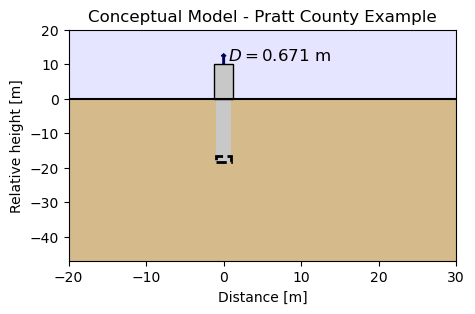

In [2]:
import matplotlib.pyplot as plt

##Now printing the conceptual model figure:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-20, 0), width=50, height=20, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-20, -47.87),
    width=50,
    height=47.87,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

well = plt.Rectangle(
    (-1, -(16.77 + 1.52)),
    width=2,
    height=(16.77 + 1.52),
    fc=np.array([200, 200, 200]) / 255,
    zorder=1,
)
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle(
    (-1.25, 0),
    width=2.5,
    height=10,
    fc=np.array([200, 200, 200]) / 255,
    zorder=2,
    ec="k",
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-1, -(16.77 + 1.52)),
    width=2,
    height=1.52,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=0, y=10, dx=0, dy=3, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=0.5, y=11, s=r"$ D = 0.671$ m", fontsize="large")

# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="k")
ax.add_line(line)


ax.set_xlim([-20, 30])
ax.set_ylim([-47, 20])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model - Pratt County Example");

## Step 2. Set basic parameters

In [3]:
rw = 0.125  # well radius, m
rc = 0.064  # well casing radius, m
L = 1.52  # screen length, m
b = -47.87  # aquifer thickness, m
zt = -16.77  # depth to top of screen, m
H0 = 0.671  # initial displacement in the well, m
zb = zt - L  # bottom of screen, m

## Step 3. Calculate the added volume

As we will see later, the input for the slug test in TTim is the added or removed volume. Therefore we must first convert our measured displacement into volume.

In [4]:
Q = np.pi * rc**2 * H0
print("slug:", round(Q, 5), "m^3")

slug: 0.00863 m^3


## Step 4. Load data from well

Data from the slug well is loaded from a text file, where the first column is the time in seconds and the second column is the head.

In [5]:
data = np.loadtxt("data/slug.txt", skiprows=1)
to = data[:, 0] / 60 / 60 / 24  # convert time to days
ho = data[:, 1]

## Step 5. Create a conceptual model in TTim

We conceptualize the aquifer as a three-layer model, one layer above the screen, one layer at the screen top and bottom and another layer just below it.

We use ```Model3D``` method to build this model. Details on how to set the model can be seen in notebook: [Unconfined - 1 - Vennebulten](unconfined1_vennebulten.ipynb).

The setting of the slug well is slightly different from the pumping well. We detail the differences below:
* the ```tsandQ``` argument in the ```Well``` object has a different meaning. Instead of meaning the time of start or shutdown and the pumping rate of the pumping well, it means the time a volume is instantaneously added or removed from the well. In our case, we defined it as ```[(0, -Q)]``` where ```0``` is the moment in time when we added the slug and ```Q``` is the added volume. A negative sign means a volume is added. Otherwise, it would mean an extracted volume.
* the ```wbstype``` argument is set to ```' slug'```, so TTim knows the ```tsandQ``` argument means time and instant volumes, instead of pumping rates.

In [6]:
ml = ttm.Model3D(kaq=10, z=[0, zt, zb, b], Saq=1e-4, kzoverkh=1, tmin=1e-6, tmax=0.01)
w = ttm.Well(ml, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=1, wbstype="slug")
ml.solve()

self.neq  1
solution complete


## Step 6. Model calibration

We calibrate both hydraulic conductivity and specific storage, considering uniform parameters in all layers. Since the observations are inside the pumping well, we use the `seriesinwell` function to add the observations. 

In [7]:
ca = ttm.Calibrate(ml)
ca.set_parameter(name="kaq0_2", initial=10)
ca.set_parameter(name="Saq0_2", initial=1e-4)
ca.seriesinwell(name="obs", element=w, t=to, h=ho)
ca.fit()

............................
Fit succeeded.


In [8]:
display(ca.parameters)

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_2,6.049085,0.023138,0.382507,-inf,inf,10.0000,"[6.049085184433308, 6.049085184433308, 6.04908..."
Saq0_2,0.000213,0.000010,4.490863,-inf,inf,0.0001,"[0.00021324705409226575, 0.0002132470540922657..."


Here we plot the results in heads over initial heads, as done for the graphical solution.

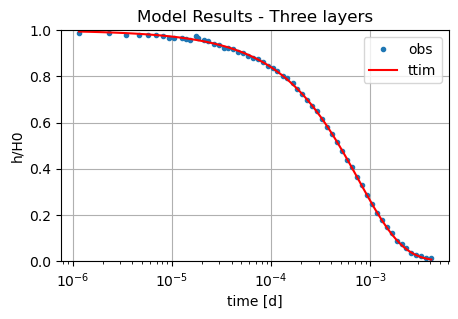

In [9]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm = ml.head(0, 0, tm, layers=1)
plt.semilogx(to, ho / H0, ".", label="obs")
plt.semilogx(tm, hm[-1] / H0, "r", label="ttim")
plt.ylim([0, 1])
plt.xlabel("time [d]")
plt.ylabel("h/H0")
plt.title("Model Results - Three layers")
plt.legend()
plt.grid()

In [10]:
ca.parameters["optimal"].values.tolist() + [ca.rmse()]

[6.049085184433308, 0.00021324705409226575, 0.002855742798130468]

In [11]:
ta = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE[m]"],
    index=["AQTESOLV", "ttim"],
)
ta.loc["ttim"] = ca.parameters["optimal"].values.tolist() + [ca.rmse()]
ta.loc["AQTESOLV"] = [4.034, 3.834e-04, 0.002976]
ta.style.set_caption("Comparison of parameter values and error under different models")

,k [m/d],Ss [1/m],RMSE[m]
AQTESOLV,4.034000,0.000383,0.002976
ttim,6.049085,0.000213,0.002856


Both models have similar (and very lowe) RMSE, but the hydraulic conductivity varies by 50%

## References
* Butler, J.J., Jr., 1998. The Design, Performance, and Analysis of Slug Tests, Lewis Publishers, Boca Raton, Florida, 252p.
* Hyder, Z., Butler Jr, J.J., McElwee, C.D., Liu, W., 1994. Slug tests in partially penetrating wells. Water Resources Research 30, 2945–2957.
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.